In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf

from keras.layers import Activation, Conv2D, MaxPooling2D,UpSampling2D, Input
from keras.layers import BatchNormalization as BN, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

In [ ]:
!wget https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
!wget https://www.dropbox.com/s/gstpamhin8rlhlg/masks.npy

--2022-05-19 21:56:36--  https://www.dropbox.com/s/qii26wuxcbxw169/images.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qii26wuxcbxw169/images.npy [following]
--2022-05-19 21:56:36--  https://www.dropbox.com/s/raw/qii26wuxcbxw169/images.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8ec75fa07bd53b4bd9fedf1877.dl.dropboxusercontent.com/cd/0/inline/BlkxV96mjArMzmC4mXN_iro1zSqiNh064brEFpTndxtaGjpBGQuYH8WDPsHXCX1IJjdwHT04xXbdZbDwbRQjk0FiRzBBQCRhPsoa9x9qpSHDla9NRkixCTxH68lhSOZR1OiSilI5ArNI_DSTziPCRakeby2SgbVqz8O0dx4mQJRhmQ/file# [following]
--2022-05-19 21:56:36--  https://uc8ec75fa07bd53b4bd9fedf1877.dl.dropboxusercontent.com/cd/0/inline/BlkxV96mjArMzmC4mXN_iro1zSqiNh064brEFpTndxtaGjpBGQuYH8WDPsHXCX1IJjdwHT04xX

In [ ]:
images=np.load("images.npy")
print(images.shape)
## Crop 512
images=images[:,0:512,0:512,:]

#im=Image.fromarray(images[0])
#im.show()

masks=np.load("masks.npy")
print(masks.shape)
## Crop 512
masks=masks[:,0:512,0:512]

#im=Image.fromarray(masks[0])
#im.show()

#Normalization
images=images/np.max(images)
masks=masks/np.max(masks)

print(np.min(masks[0]),np.max(masks[0]))



(20, 584, 584, 3)
(20, 584, 584)
0.0 1.0


In [ ]:
def ConvBlock(l, filters):
    l=Conv2D(filters, (3, 3), padding='same')(l)
    l=BN()(l)
    l=Activation('relu')(l)
    return l


def EncBlock(layer,num,filters):
    l=layer
    for i in range(num):
      l=ConvBlock(l,filters)

    return l


def DecBlock(layer,num,filters,enclayer=None):
    l=layer

    l=UpSampling2D((2,2))(layer)
    l=Conv2D(filters, (3, 3), padding='same')(l)
    l=BN()(l)
    l = Concatenate(axis=3)([l, enclayer])

    if num >= 32:
      for i in range(num):
        l=ConvBlock(l,filters)
    
    return l


def EncDec(x0):
    ## End
    x1=EncBlock(x0,2,32) # 32@512x512
    next_layer=MaxPooling2D((2,2))(x1) #  32@256x256
    x2=EncBlock(next_layer,2,64) #  64@256x256
    next_layer=MaxPooling2D((2,2))(x2) #  64@128x128
    x3=EncBlock(next_layer,2,128) # 128@128x128
    next_layer=MaxPooling2D((2,2))(x3) #  128@64x64
    x4=EncBlock(next_layer,2,256) # 256@64x64

    x_last=MaxPooling2D((2,2))(x4) #  256@32x32
    x_last=EncBlock(x_last, 2, 512) # 512@32x32
    
    ## Dec
    x5=DecBlock(x_last,2,256,x4) # 512@32x32 cat 256@64x64 = 256@64x64
    x6=DecBlock(x5,2,128,x3) #  256@64x64 cat 128@128x128 = 128@128x128
    x7=DecBlock(x6,2,64,x2) # 128@128x128 cat 64@256x256 = 64@256x256
    x8=DecBlock(x7,2,32,x1) # 64@256x256 cat 32@512x512 = 32@512x512
    out = Conv2D(2, (3, 3), padding='same')(x8) #2@512x512
    out = BN()(out)
    out = Activation('relu')(out)

    out = Conv2D(1, (1, 1), padding='same')(out) #1@512x512
    out = Activation('sigmoid')(out)

    return out


lin=Input((512,512,3))
out=EncDec(lin)

opt = Adam(learning_rate=0.001)

model = Model(inputs=lin, outputs=out)

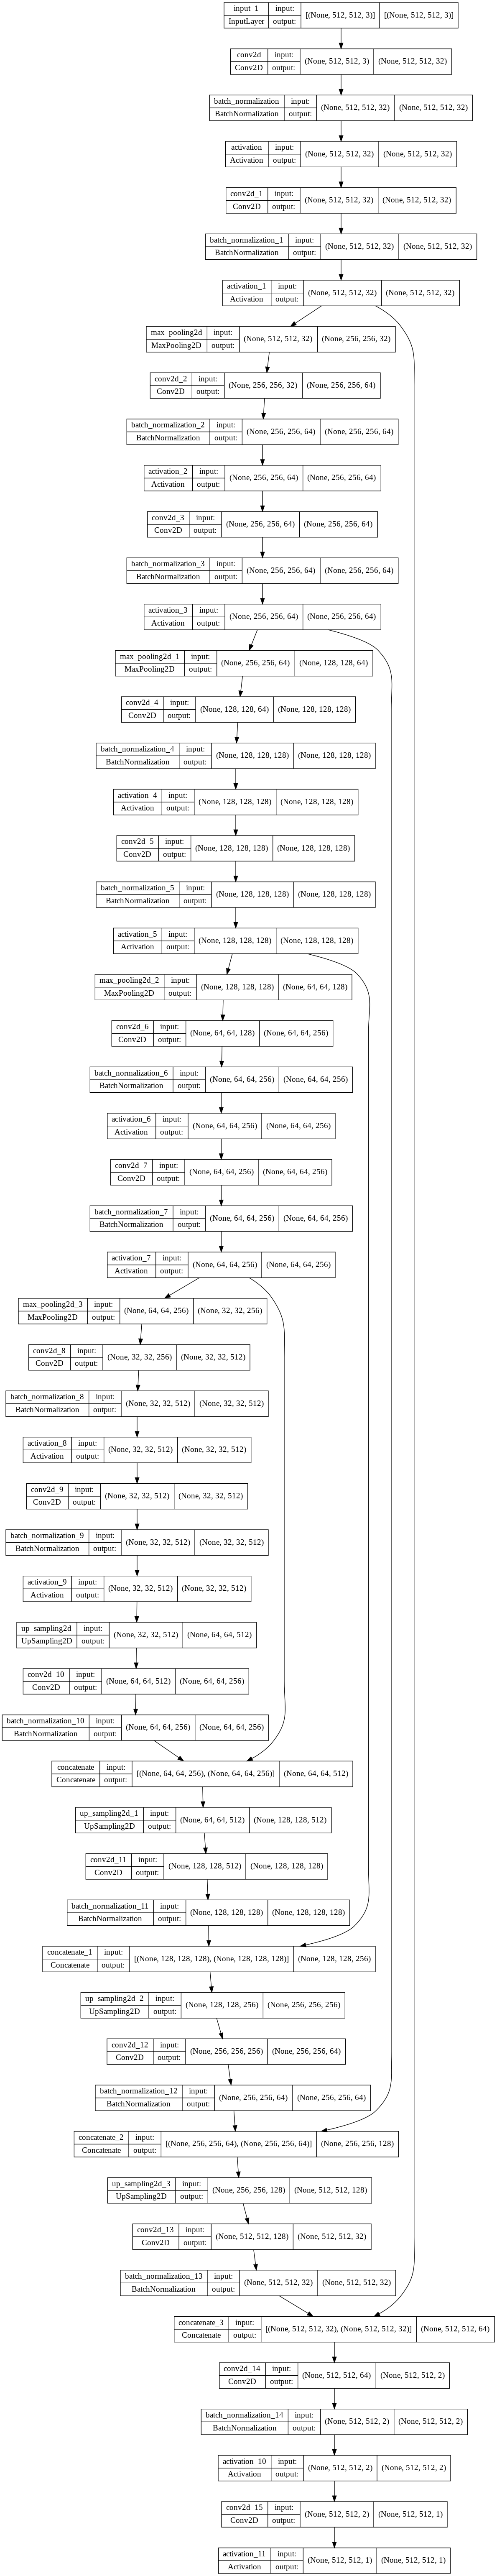

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:


model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['mse'])
    
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.1, patience=10, min_lr=0.00001)

model.fit(images,
          masks,
          batch_size=8,
          epochs=300,
          verbose=1,
          callbacks=[reduce_lr]
          )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

True mask:


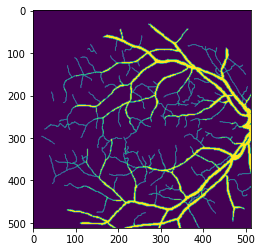

Prediction:


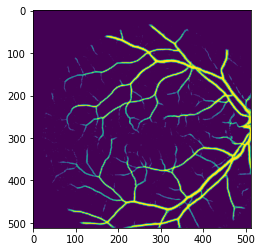

True mask:


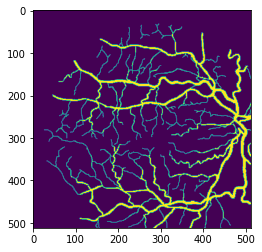

Prediction:


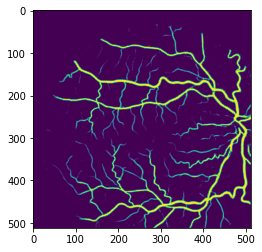

True mask:


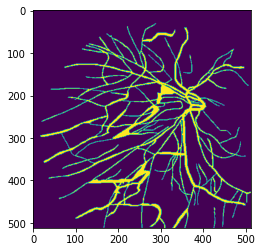

Prediction:


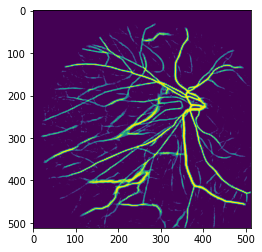

True mask:


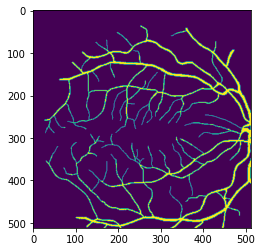

Prediction:


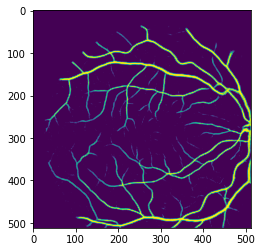

True mask:


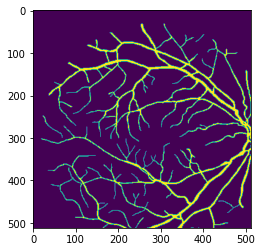

Prediction:


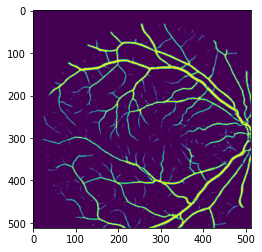

True mask:


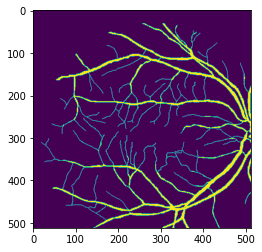

Prediction:


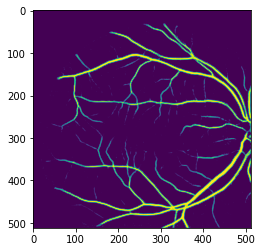

True mask:


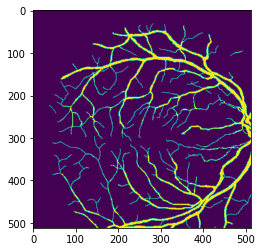

Prediction:


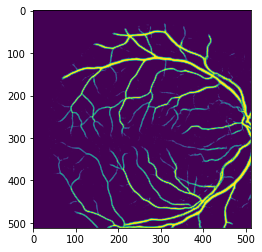

True mask:


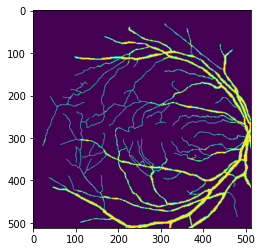

Prediction:


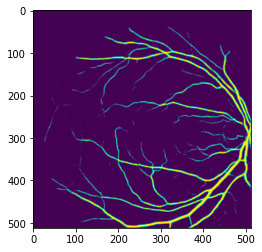

True mask:


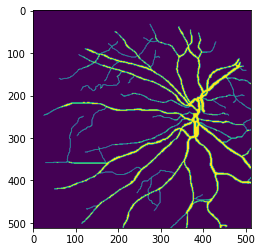

Prediction:


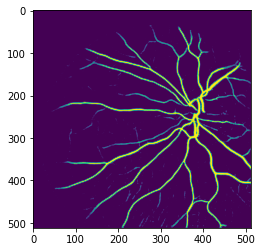

True mask:


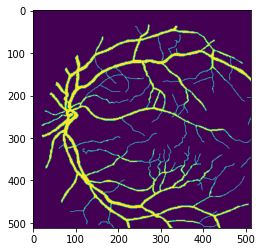

Prediction:


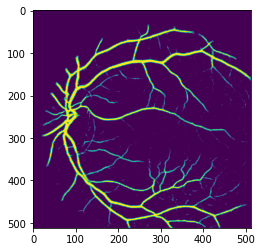

True mask:


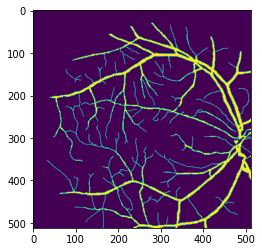

Prediction:


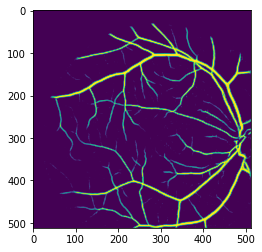

True mask:


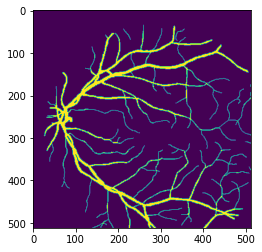

Prediction:


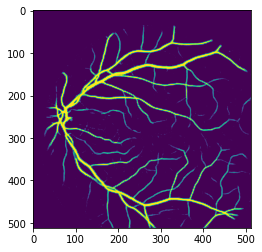

True mask:


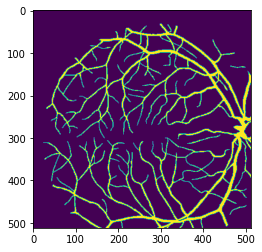

Prediction:


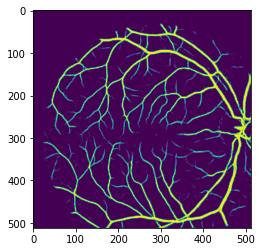

True mask:


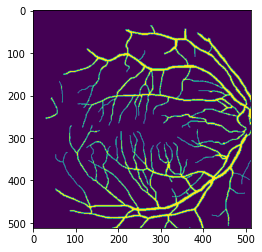

Prediction:


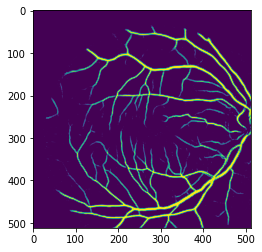

True mask:


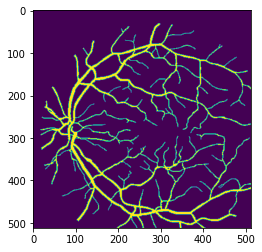

Prediction:


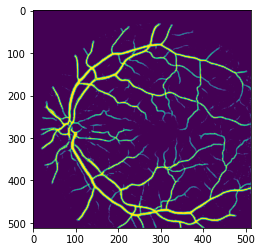

True mask:


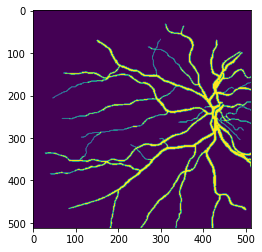

Prediction:


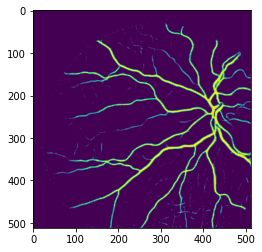

True mask:


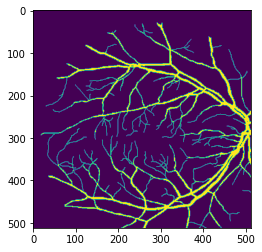

Prediction:


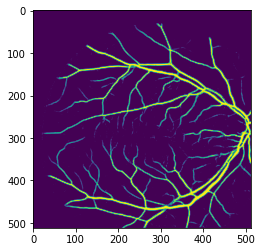

True mask:


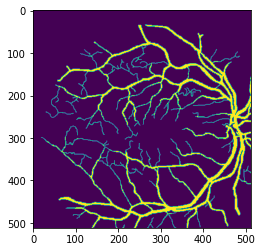

Prediction:


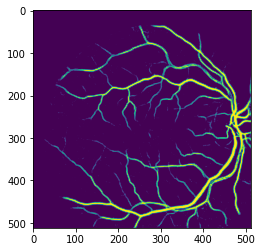

True mask:


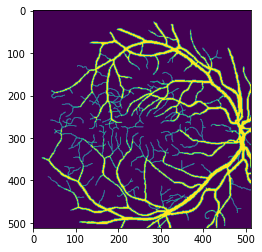

Prediction:


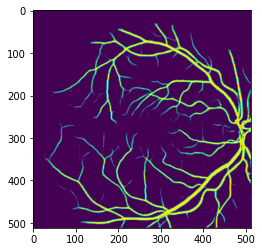

True mask:


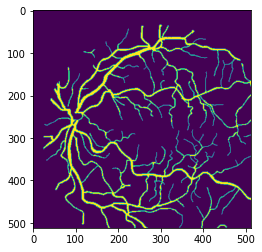

Prediction:


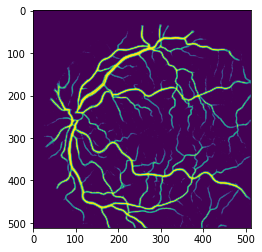

In [ ]:
import matplotlib.pyplot as plt
mask_preds = model.predict(images)
mask_preds = mask_preds * 255
mask_preds = np.uint8(mask_preds)

for index in range(images.shape[0]):
    print("True mask:")
    plt.imshow(masks[index])
    plt.show()

    print("Prediction:")
    plt.imshow(np.squeeze(mask_preds[index], axis=2))
    plt.show()